### Step 1: Import the lexicon

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np

# Function to read in the lexicon file
def read_lexicon_file(filepath):
    lexicon_df = pd.read_csv(filepath)
    return lexicon_df

# Read the lexicon file
lexicon_df = read_lexicon_file('./lemmalex.csv')

# Drop any NaN values in the 'Pronunciation' column
lexicon_df = lexicon_df.dropna(subset=['Pronunciation'])

# add log frequency column
lexicon_df['lfrq'] = np.log(lexicon_df['Frequency'] + 1)
lexicon_df.head()


,Item,Frequency,Pronunciation,lfrq
0,a,20415.27,AH,9.924087
1,abandon,8.10,AH B AE N D IH N,2.208274
2,abandonment,0.96,AH B AE N D AH N M AH N T,0.672944
3,abate,0.10,AH B EY T,0.095310
4,abbey,3.18,AE B IY,1.430311


In [2]:
# this will show that there are 17,750 words in the lexicon
len(lexicon_df), lexicon_df.describe()

(17750,
           Frequency          lfrq
 count  17750.000000  17750.000000
 mean      43.262201      1.222613
 std      651.204163      1.398385
 min        0.020000      0.019803
 25%        0.250000      0.223144
 50%        1.020000      0.703098
 75%        4.760000      1.750937
 max    41857.120000     10.642041)

### Look at frequency using histograms

Let's make a function that will plot histograms and then a 'sort plot'. The histogram plots the frequency of different values. The sort plot just sorts the values and plots them in sequence. We will see that there are a very small number of very high frequency items (like the words 'the' or 'a'). 

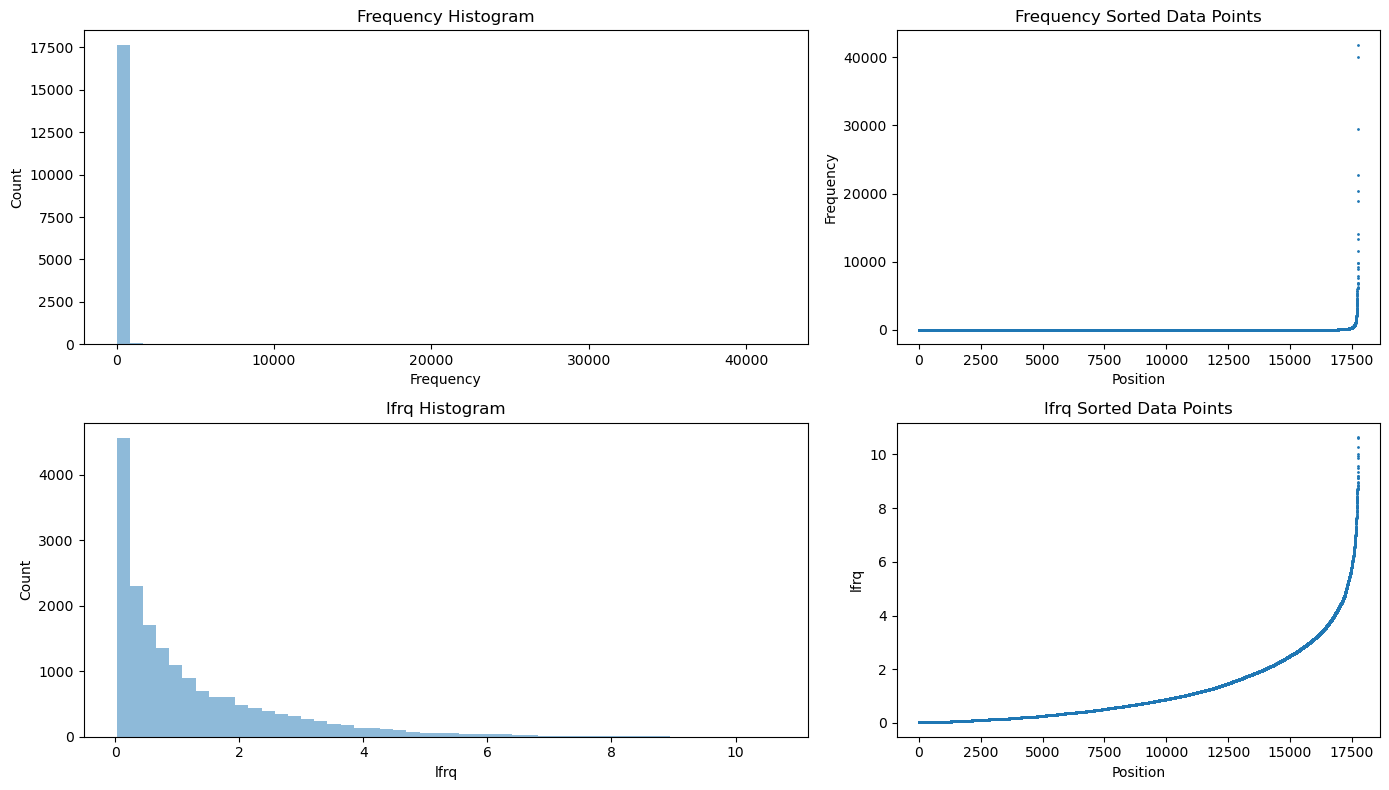

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math


def plot_histograms(df, columns, pointsize=1, alphaval = 0.5, bins=50):
    """
    Plots histograms for the specified columns of the given DataFrame.
    Adds a subplot below each histogram to show the individual data points.
    
    Parameters:
        df (DataFrame): The DataFrame containing the specified columns.
        columns (list): List of column names to plot.
    """
    # Calculate the number of rows needed for the subplots
    n_rows = len(columns)
    
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows), gridspec_kw={'width_ratios': [3, 2]})
    
    # If there's only one row, axs is a 1D array and we need to reshape it
    if n_rows == 1:
        axs = axs.reshape(1, -1)
    
    # Flatten the axs array for easy iteration
    axs = axs.flatten()
    
    # Plot histograms and individual data points
    for idx, col in enumerate(columns):
        # Plot histogram
        axs[2 * idx].hist(df[col], bins=bins, alpha=alphaval)
        axs[2 * idx].set_title(f'{col} Histogram')
        axs[2 * idx].set_xlabel(col)
        axs[2 * idx].set_ylabel('Count')
        
        # Plot individual data points sorted by value
        sorted_data = np.sort(df[col].values)
        axs[2 * idx + 1].plot(sorted_data, marker='o', linestyle='', markersize = pointsize)
        axs[2 * idx + 1].set_title(f'{col} Sorted Data Points')
        axs[2 * idx + 1].set_xlabel('Position')
        axs[2 * idx + 1].set_ylabel(col)

    # Hide any extra subplots
    for idx in range(2 * len(columns), len(axs)):
        axs[idx].axis('off')
    
    # Show the plots
    plt.tight_layout()
    plt.show()

# Example usage:
plot_histograms(lexicon_df, ['Frequency', 'lfrq'])


### Trimming based on frequency

I'll spare you the details, but having small numbers of items with very high frequency is problematic. Let's just cut items with log frequency more than 3 standard deviations above the mean. 

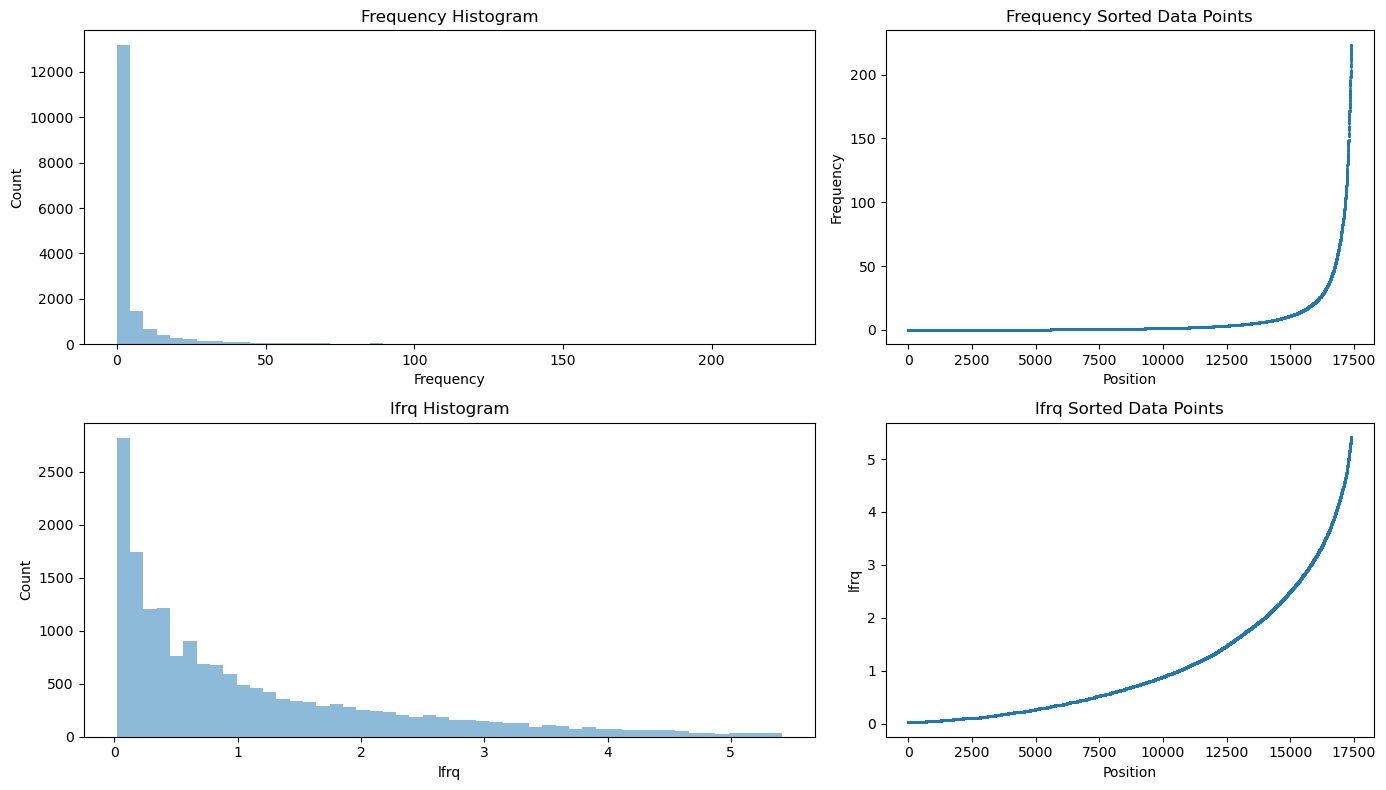

In [4]:
# Calculate mean and standard deviation of 'lfrq'
mean_lfrq = lexicon_df['lfrq'].mean()
std_lfrq = lexicon_df['lfrq'].std()

# Define the boundaries for acceptable 'lfrq' values
lower_bound = mean_lfrq - 3 * std_lfrq
upper_bound = mean_lfrq + 3 * std_lfrq

# Remove records where 'lfrq' is more than 3 standard deviations from the mean
filtered_lexicon_df = lexicon_df[(lexicon_df['lfrq'] >= lower_bound) & (lexicon_df['lfrq'] <= upper_bound)]

# replot histograms
plot_histograms(filtered_lexicon_df, ['Frequency', 'lfrq'])


This is much better. Next code cells describe and then just take the filtered lexicon as our default lexicon.

In [5]:
# much better; let's redescribe
filtered_lexicon_df.describe()

,Frequency,lfrq
count,17397.000000,17397.000000
mean,7.590574,1.112872
std,21.898453,1.168418
min,0.020000,0.019803
25%,0.240000,0.215111
50%,0.960000,0.672944
75%,4.240000,1.656321
max,223.550000,5.414098


In [6]:
# let's just replace lexicon_df with the filtered one
lexicon_df = filtered_lexicon_df

### Phoneme similarity

We are going to do simulations by presenting one phoneme at a time. We could use 'localist' or 'one-hot' representations, where each phoneme has a discrete value and no similarity to other phonemes. However, we know from a century of research that humans perceive some phonemes (e.g., 'b' and 'p') as more similar than others (e.g., 'b' and 'a' are not similar). So we want to include this in our simulation. If the word is 'bat', the phoneme /b/ should give us high evidence that /b/ has occurred, but also moderate evidence that /p/ may have occurred, and very low evidence that /o/ occurred (because /b/ is quite similar to /p/ but quite different from /o/, phonetically). 

There are various ways to estimate similarity. For example, we can present phonemes in noise to listeners and ask them to transcribe what they hear. Then we can calculate 'confusability' or similarity as how often, for example, people answered 'p' when the actual input was 'b'. 

There are a *lot* of potential sources for such 'confusion' data, but it is not obvious how to use it. For example, Luce (1986) argued in his dissertation that his confusion data could not generalize beyond the specific conditions under which it was collected -- it applied for a particular level of noise, etc. 

I have colleagues in Spain who are working on some new, very principled approaches. While we wait for them to supply their similarity matrices, let's figure out a way to do our own.

### Phonetic similarity

We could use featural definitions of phonemes. For example, /p/ and /b/ are both bilabial stops. The only difference is that /b/ is 'voiced' while /p/ is 'voiceless'. We could compare phonemes on their featural similarity. We might do this later... However, it would be nice to have a method that does not depend on us knowing the featural definitions (in case we want to extend to another language where that information is not readily available). 

### Context similarity

It turns out that we can learn a lot about some element (phoneme, word, object) by the company it keeps. Let's just go through the lexicon and count how many times any phoneme pair co-occurs adjacently. So for example, the word 'cat' has the phonemes /k/, /æ/, and /t/. So we could increment the count for /kæ/ and /æt/, the two pairs of phonemes that occur. To tabulate this, we'll make a phoneme-by-phoneme matrix. So for cat, we would increment the counts for {k,æ}, {æ, k}, {æ, t}, and {t, æ}. However, we should also adjust this for word frequency. The word cat occurs fairly often, so we would want to boost these counts a bit more than the counts for the same pairs from the word catalytic. We will use word frequency to do this. 

What we will end up with is a phoneme-by-phoneme matrix that counts how often each phoneme occurs with every other phoneme. 

In [7]:

# Extract unique phonemes
unique_phonemes = set()
for pronunciation in lexicon_df['Pronunciation']:
    phonemes = pronunciation.split()
    unique_phonemes.update(phonemes)
sorted_unique_phonemes = sorted(list(unique_phonemes))
num_phonemes = len(sorted_unique_phonemes)
phoneme_to_index = {phoneme: index for index, phoneme in enumerate(sorted_unique_phonemes)}

# Create a weighted matrix for phoneme pairs
weighted_phoneme_matrix_dict = defaultdict(float)
# create dictionary for frequency-weighted counts of each phoneme
phoneme_count_dict = defaultdict(float)


# Now let's fill the matrix
fweight = 1.0 # how much to use frequency; when set to 1, just use full value
for _, row in lexicon_df.iterrows():
    pronunciation, lfrq = row['Pronunciation'], row['lfrq']
    phonemes = pronunciation.split()
    
    # Update the frequency-weighted count for each individual phoneme
    for phoneme in phonemes:
        phoneme_count_dict[phoneme] += (lfrq * fweight)
 
    for i in range(len(phonemes) - 1):
        first_phoneme, second_phoneme = phonemes[i], phonemes[i + 1]
        weighted_phoneme_matrix_dict[(first_phoneme, second_phoneme)] += (lfrq * fweight)
        weighted_phoneme_matrix_dict[(second_phoneme, first_phoneme)] += (lfrq * fweight)


# Initialize the weighted matrix
weighted_phoneme_matrix = np.zeros((num_phonemes, num_phonemes), dtype=float)
for (first, second), count in weighted_phoneme_matrix_dict.items():
    i, j = phoneme_to_index[first], phoneme_to_index[second]
    weighted_phoneme_matrix[i, j] = count

# Convert the matrix to a DataFrame for better readability
weighted_phoneme_matrix_df = pd.DataFrame(weighted_phoneme_matrix, index=sorted_unique_phonemes, columns=sorted_unique_phonemes)

# Convert the phoneme_count_dict to a DataFrame for better readability
phoneme_count_df = pd.DataFrame(list(phoneme_count_dict.items()), columns=['Phoneme', 'FrequencyWeightedCount']).sort_values(by='FrequencyWeightedCount', ascending=False)

# Calculate the sum of all FrequencyWeightedCount values
total_count = phoneme_count_df['FrequencyWeightedCount'].sum()

# Add a new column for normalized probabilities
phoneme_count_df['phon_prob'] = phoneme_count_df['FrequencyWeightedCount'] / total_count

# Create a simpler dictionary that just pairs phonemes with their normalized probabilities (phon_prob)
phoneme_prob_dict = dict(zip(phoneme_count_df['Phoneme'], phoneme_count_df['phon_prob']))
phoneme_prob_dict

# Display a portion of the weighted matrix and phoneme count matrix for review
weighted_phoneme_matrix_df.iloc[:10, :5], phoneme_prob_dict#,phoneme_count_df.iloc[:100, :10]


(            AA          AE           AH         AO         AW
 AA    0.000000    0.000000     0.000000   0.000000   0.000000
 AE    0.000000    0.000000     0.000000   0.000000   0.000000
 AH    0.000000    0.000000     1.280758   1.350667  39.343166
 AO    0.000000    0.000000     1.350667   0.000000   0.000000
 AW    0.000000    0.000000    39.343166   0.000000   0.000000
 AY    7.207485    5.742495   102.973433   2.414126   0.000000
 B   185.558680  283.949295  1000.629454  54.270354  24.262590
 CH   40.617086  108.511521   210.936280   5.700518  10.245048
 D   134.052686  186.728707   844.436416  55.920047  56.054154
 DH    8.222988   14.214397    90.675537   0.000000   3.154017,
 {'AH': 0.1041717568844594,
  'R': 0.08762797978723763,
  'IH': 0.0799592708972376,
  'T': 0.06813767731764012,
  'N': 0.06763029365957593,
  'S': 0.06098663594854901,
  'L': 0.05478876040112506,
  'K': 0.04727856415076621,
  'D': 0.03389393117466113,
  'IY': 0.033529270909775345,
  'P': 0.033084815530742

In [8]:
probability_for_AH = phoneme_prob_dict.get("AH", "Phoneme not found")
probability_for_AH

0.1041717568844594

### Converting counts to similarities

Once we have the matrix, now we can take the rows or columns as 'representations' of each phoneme, in terms of how often the phoneme co-occurs with other phonemes. To get pairwise similarity, we could compare the Euclidean distance of the vectors. Another approach is to use *cosine* similarity. 

## Cosine Similarity

Cosine similarity is a metric used to determine the cosine of the angle between two non-zero vectors in an inner product space. It is used to measure how similar two vectors are. The cosine similarity is particularly used in positive space, where the outcome is neatly bounded in [0,1].

The formula to find the cosine similarity between two vectors $ A $ and $ B $ is given by:

$$
\text{Cosine Similarity} = \cos(\theta) = \frac{{A \cdot B}}{{\|A\| \times \|B\|}}
$$

Where $ A \cdot B $ is the dot product of the vectors $ A $ and $ B $, and $ \|A\| $ and $ \|B\| $ are the magnitudes (or Euclidean norms) of vectors $ A $ and $ B $ respectively.

### Properties of Cosine Similarity

1. **Directions rather than length/distance**: Cosine similarity focuses only on the orientation of vectors, not their magnitude. 

2. **Efficient to Compute**: For sparse vectors, cosine similarity is generally more efficient to compute than Euclidean distance.

3. **Bounded Range**: Cosine similarity ranges from -1 to 1, making it easy to interpret.

### Example

Consider two vectors $ A = [1, 2] $ and $ B = [2, 3] $.

1. **Dot Product $ A \cdot B $**:
$$
A \cdot B = 1 \times 2 + 2 \times 3 = 2 + 6 = 8
$$

2. **Magnitude of A $ \|A\| $**:
$$
\|A\| = \sqrt{1^2 + 2^2} = \sqrt{1 + 4} = \sqrt{5}
$$

3. **Magnitude of B $ \|B\| $**:
$$
\|B\| = \sqrt{2^2 + 3^2} = \sqrt{4 + 9} = \sqrt{13}
$$

4. **Cosine Similarity**:
$$
\text{Cosine Similarity} = \frac{8}{\sqrt{5} \times \sqrt{13}} \approx 0.9839
$$

The value is close to 1, indicating that the vectors are very similar in orientation.

To make it very clear that cosines are about *directions*, let's redefine $B$ as $[2, 4]$ and recalculate. To calculate the cosine similarity between vectors $ A = [1, 2] $ and $ B = [2, 4] $, the formula is:

$$
\text{Cosine Similarity} = \frac{A \cdot B}{||A|| \times ||B||}
$$

1. **Dot Product $ A \cdot B $**: $ (1 \times 2) + (2 \times 4) = 2 + 8 = 10 $
2. **Euclidean Norm $ ||A|| $**: $ \sqrt{1^2 + 2^2} = \sqrt{1 + 4} = \sqrt{5} $
3. **Euclidean Norm $ ||B|| $**: $ \sqrt{2^2 + 4^2} = \sqrt{4 + 16} = \sqrt{20} $
4. **Cosine Similarity**: $ \frac{10}{\sqrt{5} \times \sqrt{20}} = \frac{10}{\sqrt{100}} = \frac{10}{10} = 1 $

The cosine similarity is 1, indicating that the vectors are identical in orientation. This will be true when the vectors are *scalars* of each other (multiples; i.e., there is a single value you can multiply vector $A$ by that will give you vector $B$). So $A = [1, 2]$ and $B = [4, 8]$ are scalars since $A \times 8 = B$. The cosine of $A = [1, 2]$ and $B = [.5, 1]$ will also be 1 because $A \times 0.5 = B$.When cosine is 1, this means the vectors *point* in the same direction, even though they may have different lengths. When vectors have a cosine of -1 (e.g., $A = [1, 2]$ and $B = [-4, -8]$) they point in opposite directions.

---

***Note.*** The operation in linear algebra that gives the magnitude of a vector is known as the vector norm. Specifically, the Euclidean norm (or $ L_2 $ norm) is commonly used to calculate the magnitude of a vector $ \mathbf{v} $ in Euclidean space. The formula for the Euclidean norm of a vector $ \mathbf{v} = [v_1, v_2, \ldots, v_n] $ is:

$$
\|\mathbf{v}\| = \sqrt{v_1^2 + v_2^2 + \ldots + v_n^2}
$$

The Euclidean norm provides a measure of the "length" of the vector from the origin to the point represented by the vector in $ n $-dimensional space.

---

So: let's get cosine similarities using a the sci-kit-learn library.

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity between each pair of phoneme vectors
cosine_sim_matrix = cosine_similarity(weighted_phoneme_matrix)

# Convert the similarity matrix to a DataFrame for better readability
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=sorted_unique_phonemes, columns=sorted_unique_phonemes)

# Display a portion of the cosine similarity matrix
cosine_sim_df.iloc[:10, :10]


,AA,AE,AH,AO,AW,AY,B,CH,D,DH
AA,1.000000,0.966031,0.931129,0.848900,0.757327,0.785100,0.258615,0.311287,0.359275,0.116166
AE,0.966031,1.000000,0.948020,0.808589,0.845911,0.856638,0.242135,0.328735,0.371903,0.096337
AH,0.931129,0.948020,1.000000,0.892759,0.798543,0.891911,0.295744,0.334902,0.415630,0.130527
AO,0.848900,0.808589,0.892759,1.000000,0.566249,0.766836,0.306023,0.243556,0.328706,0.143260
AW,0.757327,0.845911,0.798543,0.566249,1.000000,0.814663,0.268305,0.461216,0.487079,0.183749
AY,0.785100,0.856638,0.891911,0.766836,0.814663,1.000000,0.358534,0.364591,0.413384,0.206859
B,0.258615,0.242135,0.295744,0.306023,0.268305,0.358534,1.000000,0.820980,0.765612,0.933101
CH,0.311287,0.328735,0.334902,0.243556,0.461216,0.364591,0.820980,1.000000,0.950619,0.757804
D,0.359275,0.371903,0.415630,0.328706,0.487079,0.413384,0.765612,0.950619,1.000000,0.692227
DH,0.116166,0.096337,0.130527,0.143260,0.183749,0.206859,0.933101,0.757804,0.692227,1.000000


We can see that self-similarity (cosine) is 1.0 for all phonemes. We can also see that some pairs have extremely high cosines -- e.g., $[/AA/, /AE/]= 0.966031$. This is probably too high. Let's downweight the non-identity similarities by dividing them by a constant.

In [10]:
# Adjust the diagonal entries from 1.0 to 0.9
#np.fill_diagonal(cosine_sim_matrix, 0.9)

# Halve the off-diagonal entries -- actually by 5
off_diagonal_indices = np.where(~np.eye(cosine_sim_matrix.shape[0], dtype=bool))
adjusted_cosine_sim_matrix = cosine_sim_matrix.copy()
adjusted_cosine_sim_matrix[off_diagonal_indices] /= 5.0

# Convert the adjusted similarity matrix to a DataFrame for better readability
adjusted_cosine_sim_df = pd.DataFrame(adjusted_cosine_sim_matrix, index=sorted_unique_phonemes, columns=sorted_unique_phonemes)

# Display a portion of the adjusted cosine similarity matrix
adjusted_cosine_sim_df.iloc[:10, :10]


,AA,AE,AH,AO,AW,AY,B,CH,D,DH
AA,1.000000,0.193206,0.186226,0.169780,0.151465,0.157020,0.051723,0.062257,0.071855,0.023233
AE,0.193206,1.000000,0.189604,0.161718,0.169182,0.171328,0.048427,0.065747,0.074381,0.019267
AH,0.186226,0.189604,1.000000,0.178552,0.159709,0.178382,0.059149,0.066980,0.083126,0.026105
AO,0.169780,0.161718,0.178552,1.000000,0.113250,0.153367,0.061205,0.048711,0.065741,0.028652
AW,0.151465,0.169182,0.159709,0.113250,1.000000,0.162933,0.053661,0.092243,0.097416,0.036750
AY,0.157020,0.171328,0.178382,0.153367,0.162933,1.000000,0.071707,0.072918,0.082677,0.041372
B,0.051723,0.048427,0.059149,0.061205,0.053661,0.071707,1.000000,0.164196,0.153122,0.186620
CH,0.062257,0.065747,0.066980,0.048711,0.092243,0.072918,0.164196,1.000000,0.190124,0.151561
D,0.071855,0.074381,0.083126,0.065741,0.097416,0.082677,0.153122,0.190124,1.000000,0.138445
DH,0.023233,0.019267,0.026105,0.028652,0.036750,0.041372,0.186620,0.151561,0.138445,1.000000


This looks better. Let's normalize the values though to treat them like probabilities. 

In [11]:
# Normalize the rows of the adjusted cosine similarity matrix so they sum to 1
row_sums = adjusted_cosine_sim_matrix.sum(axis=1)
normalized_cosine_sim_matrix = adjusted_cosine_sim_matrix / row_sums[:, np.newaxis]

# Convert the normalized similarity matrix to a DataFrame for better readability
normalized_cosine_sim_df = pd.DataFrame(normalized_cosine_sim_matrix, index=sorted_unique_phonemes, columns=sorted_unique_phonemes)

# Display a portion of the normalized cosine similarity matrix
normalized_cosine_sim_df.iloc[:10, :10]




,AA,AE,AH,AO,AW,AY,B,CH,D,DH
AA,0.231184,0.044666,0.043052,0.039250,0.035016,0.036300,0.011958,0.014393,0.016612,0.005371
AE,0.043542,0.225367,0.042730,0.036446,0.038128,0.038612,0.010914,0.014817,0.016763,0.004342
AH,0.041180,0.041927,0.221132,0.039483,0.035317,0.039446,0.013080,0.014811,0.018382,0.005773
AO,0.041679,0.039700,0.043833,0.245491,0.027802,0.037650,0.015025,0.011958,0.016139,0.007034
AW,0.034274,0.038283,0.036140,0.025627,0.226284,0.036869,0.012143,0.020873,0.022044,0.008316
AY,0.032920,0.035920,0.037399,0.032154,0.034160,0.209655,0.015034,0.015288,0.017334,0.008674
B,0.009705,0.009087,0.011098,0.011484,0.010069,0.013455,0.187634,0.030809,0.028731,0.035016
CH,0.011055,0.011675,0.011894,0.008650,0.016379,0.012948,0.029156,0.177568,0.033760,0.026912
D,0.012692,0.013139,0.014683,0.011613,0.017208,0.014604,0.027048,0.033583,0.176640,0.024455
DH,0.004986,0.004135,0.005602,0.006149,0.007886,0.008878,0.040048,0.032524,0.029710,0.214597


When we divide non-identity values by 2, the normalized values wind up being around 0.1 for identity and 0.05 for highly similar items. These may be too similar, so I've instead divided by 5. This makes the identity values around 0.22 and high sim items 0.04. Might not be perfect, but let's try this. 

### Visualizing similarity

A simple and effective way to visualize similarity when we have a matrix is to use a *heatmap*, where color indicates value. 

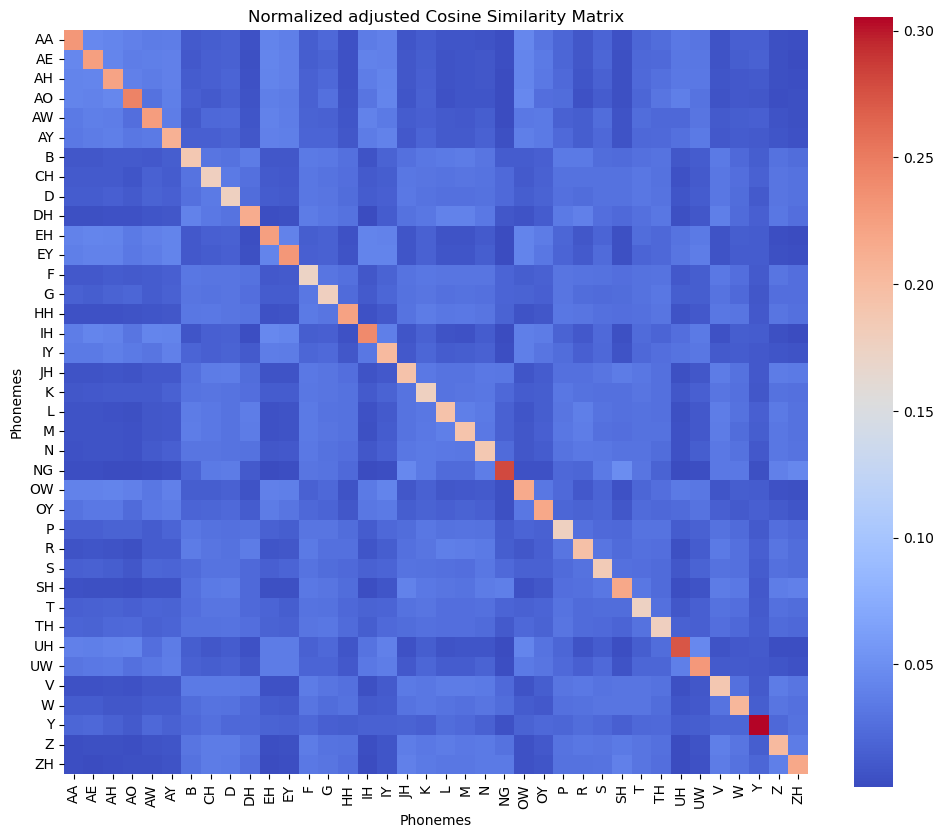

In [12]:
# let's visualize it

import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(normalized_cosine_sim_df, annot=False, cmap="coolwarm", cbar=True, square=True)

# Add labels and title
plt.title("Normalized adjusted Cosine Similarity Matrix")
plt.xlabel("Phonemes")
plt.ylabel("Phonemes")

# Adjust the font size of the tick labels
# plt.xticks(fontsize=6)
# plt.yticks(fontsize=8)

# Show the plot
plt.show()


So we can definitely see structure here. But phonemes are sorted alphabetically. Could we resort in some way to put similar things near similar things? Let's use a standard *clustering* technique called *hierarchical clustering* and then recreate the heatmap. 

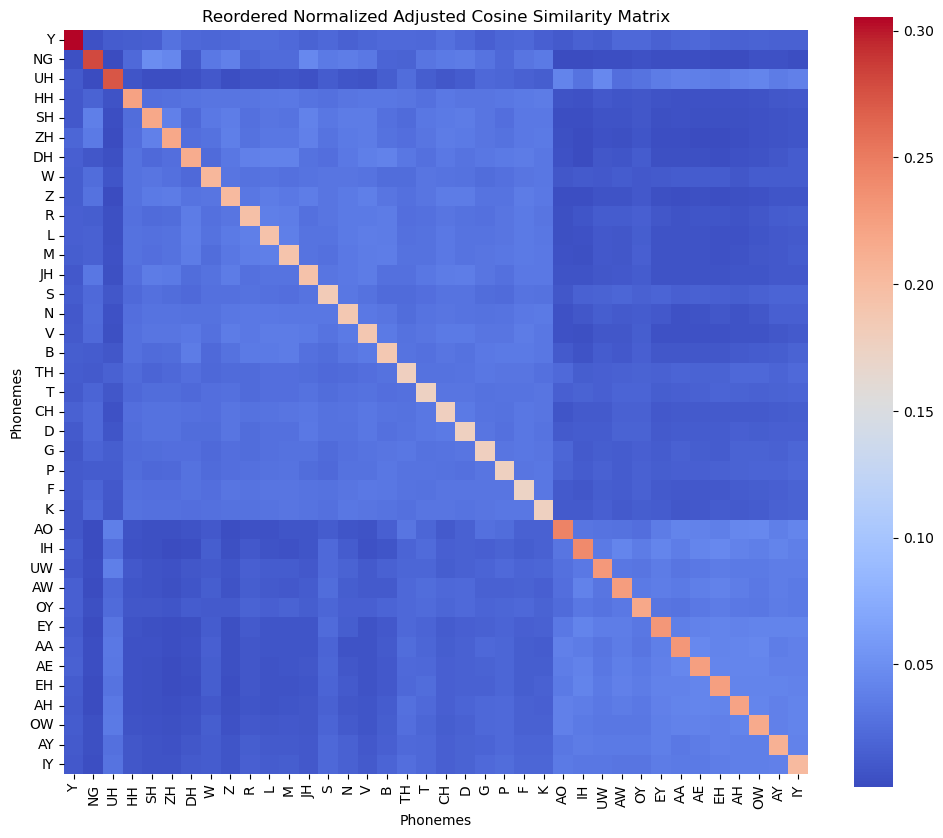

In [13]:
# Let's cluster first

from scipy.cluster.hierarchy import linkage, leaves_list
import seaborn as sns

# Perform hierarchical clustering
link = linkage(normalized_cosine_sim_df, method='average')

# Get the order of rows according to the hierarchy
row_order = leaves_list(link)

# Reorder the DataFrame
sorted_unique_phonemes = np.array(sorted_unique_phonemes)  # Assuming it's a list; convert to NumPy array
sorted_unique_phonemes = sorted_unique_phonemes[row_order]

# Reorder rows and columns based on hierarchical clustering
reordered_df = normalized_cosine_sim_df.loc[sorted_unique_phonemes, sorted_unique_phonemes]

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(reordered_df, annot=False, cmap='coolwarm', cbar=True, square=True)
plt.title("Reordered Normalized Adjusted Cosine Similarity Matrix")
plt.xlabel("Phonemes")
plt.ylabel("Phonemes")
plt.show()


Much better! we can now see consonants and vowels tend to be grouped together. However, there's a big gap between identity (.2-.3) and high cosine values (which we scaled down to less than 0.05). This means we are not using the color scale completely. Let's leave out the high values and see if we can improve the heatmap. 

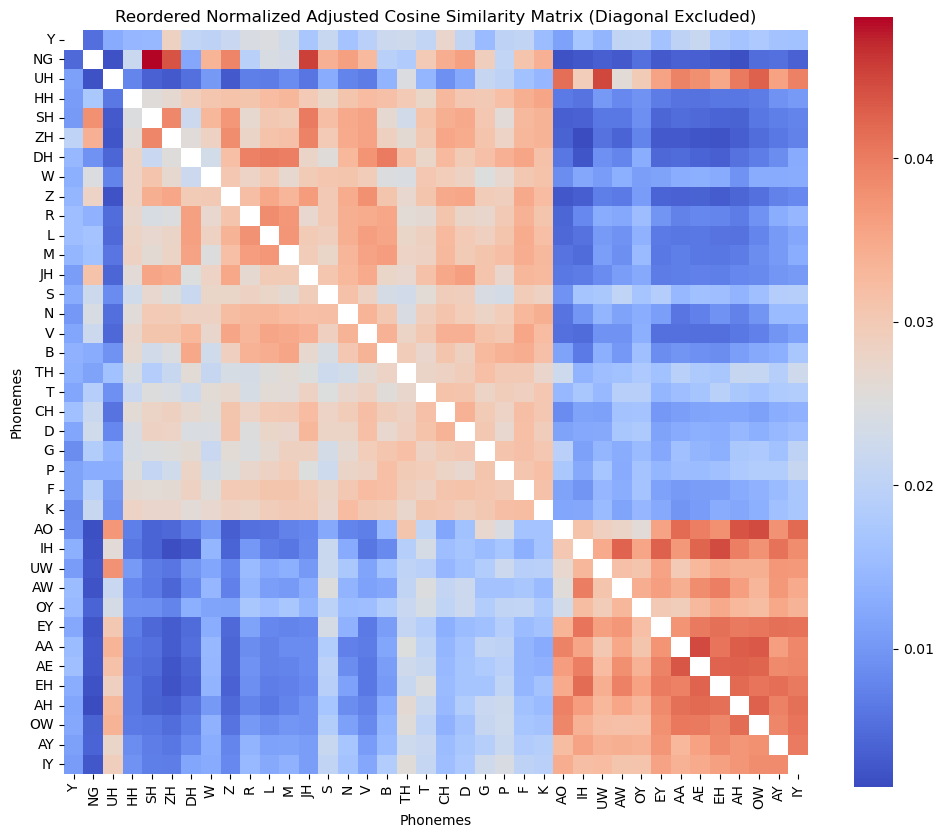

In [14]:
# Let's leave the identity positions out to make the scale smaller

# Set the diagonal entries to NaN
np.fill_diagonal(reordered_df.values, np.nan)
# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(reordered_df, annot=False, cmap='coolwarm', cbar=True, square=True, mask=np.isnan(reordered_df))
plt.title("Reordered Normalized Adjusted Cosine Similarity Matrix (Diagonal Excluded)")
plt.xlabel("Phonemes")
plt.ylabel("Phonemes")
plt.show()


Much better again; now we can really see the structure. It may be that this is not a good basis for estimating human perceptual similarity, but it seems to get the basics correct. 

---



### Bayesian Approach to Spoken Word Recognition

In a Bayesian framework for word recognition, we must work with probabilities conditioned on observed evidence. For our first attempt, we are going to try to follow the fairly simple logic of the Shortlist B model (Norris & McQueen, 2008). We will simulate spoken word recognition by processing one phoneme at a time. The idea is to update our beliefs (probabilities) about which word is being spoken as new phonemes are observed.


#### 1. Bottom-up phoneme probabilities

An assumption on the Shortlist approach is that we will evaluate the evidence for phonemes (which I will also call *segments* so we can use the variable $s$ instead of $p$) purely on the basis of bottom-up input. This means that even at later positions, we will not evaluate the conditional probability of a phoneme at the current evidence given both the current bottom-up evidence *and* the preceding sequence. 

So for each phoneme, we will just retrieve $P(Evidence|Phoneme)$. We will get this simply as the normalized similarites from the dataframe `normalized_cosine_sim_df`. So when the current phoneme is /b/, we just take the B column from that matrix, where the probability of B will be fairly high (around 0.22) while other phoneme probabilities will be quite a bit lower (max around 0.05). The idea is that when each phoneme might be present, these similarities are giving us the probability that this 'Evidence' (signal) would be present. This is possibly a point we may need to re-assess later, but we'll work with it for now. 

So at each position, we will retrieve the appropriate list of probabilities from `normalized_cosine_sim_df` and that's our evidence. However, we have to get to this (Equation 3 from Norris & McQueen, 2008) to get the posterior probability of each phoneme: 

$$
P(Phoneme_{i}|Evidence)=\frac{P(Evidence|Phoneme_{i}) \times P(Phoneme_{i})}{\sum\limits_{j=1}^{j=m}P(Evidence|Phoneme_{j}) \times P(Phoneme_{j})}
$$

where there are $m$ phonemes in the set. 

So we also need to get the phoneme probabilities from `phoneme_count_df`. Then we just multiply the `normalized_cosine_sim_df` by the `phon_prob` field in the `phoneme_count_df` dataframe. 

We cacluate the numerator for each phoneme and sum up all the results (which is equivalent to the denominator). Then we divide each value by that sum.  

#### 2. Prior Probability (Word Frequency)

Before any phonemes are observed, our belief about which word is likely to be spoken would be based on the frequency with which each word occurs in the language. This is our *prior distribution*,  $ P(W) $, where $ W $ is the set of all possible words. In the simplest case, we convert freqencies to probabilities by normalizing them -- we divide each word's frequency by the sum of all words' frequencies.

#### 3. Likelihood (words)

As each new phoneme is observed, we want to update our estimate of how likely each word is to be the current word (that is coming in phoneme-by-phoneme). So we take the $PhonemeString$ that has emerged so far as the Evidence, and then need to calculate $P(Word_{i}|Evidence)$ for each word $i$ (that is, we need to calculate the probability of word $i$ given the input thus far). We can do this using Equation 4 from Norris & McQueen. 

$$
Likelihood = P(Evidence|Word_{i})=P(PhonemeString_{i})=\prod\limits_{j=1}^{l}P(Phoneme_{j}|Evidence)
$$

So this says that we will take the product of all the $P(Phoneme_{j}|Evidence)$ for all $l$ phonemes. So if the input word is 'cat', the phonemes are $K, AA, T$, and we would calculate $P(K|K) \times P(AA|AA) \times P(T|T)$ (e.g., where $P(T|T)$ the value we get for $T$ when the input is $T$ from `nomalized_cosine_sim_df` $\times$ the `phon_prob` value from `phoneme_count_df`.

#### 4. Posterior Probability (words)

Then to get the posterior probability for each word at the current position, we use Equation 5 from Norris & McQueen.

$$
P(Word_{i}|Evidence)=\frac{P(Evidence|Word_{i}) \times P(Word_{i})}
{\sum\limits_{j=1}^{j=n}P(Evidence|Word_{j}) \times P(Word_{j})}
$$

which we can calculate by using $PhonemeString$ values:

$$
Posterior = P(Word_{i}|Evidence)=\frac{P(PhonemeString_{i}) \times P(Word_{i})}
{\sum\limits_{j=1}^{j=n}P(PhonemeString_{j}) \times P(Word_{j})}
$$

So we will do this at each phoneme position. 

#### 5. Normalization

For each step, we always have to do a final normalization so that any quantities that we want to be probabilities sum to 1.0.

---

Let's try to implement this model! 

Okay, we have simulated one word! How can we visualize the results? Let's make a function that will generate a plot from the kind of result we get from our simulation function. 

In [15]:
import time
from collections import defaultdict

def simulate_word_bayesian_current(target_word, lexicon_df, adjusted_cosine_sim_df, threshold=0.000005, topX=100):
    
    """
        simulate_word_bayesian(target_word, lexicon_df, adjusted_cosine_sim_df)

        Simulates the process of word recognition based on Bayesian inference.

        This function takes in a target word, a lexicon DataFrame, and an adjusted 
        cosine similarity DataFrame. It simulates how the target word would be 
        recognized phoneme-by-phoneme, based on a Bayesian model that updates word 
        probabilities at each phoneme position.

        Parameters:
            - target_word (str): The word that the simulation aims to recognize.
            - lexicon_df (DataFrame): A DataFrame containing the lexicon. 
                                      Columns should include 'Item' for the word and 
                                      'lfrq' for the log frequency.
            - adjusted_cosine_sim_df (DataFrame): A DataFrame containing the adjusted 
                                                  cosine similarity between phonemes.

        Returns:
            - final_result_df (DataFrame): A DataFrame containing the simulation results. 
                                           This includes probabilities of different words 
                                           at each phoneme position for the target word.

        The function also prints the elapsed time for processing each phoneme and the 
        total elapsed time for the entire simulation.

        Example usage:
            sim_result = simulate_word_bayesian('abandon', lexicon_df, adjusted_cosine_sim_df)
    """
    start_time = time.time() # just noting the time when we start for time reports later
    
    # Get the pronunciation of the target word
    target_pronunciation = lexicon_df.loc[lexicon_df['Item'] == target_word, 'Pronunciation'].values[0]
    target_phonemes = target_pronunciation.split()
    
    # Initialize a list to store the results
    result_list = []
    # Initialize an empty list to store phoneme probabilities
    phoneme_prob_list = []
    
    # Initialize a dictionary to store the prior probabilities for each word based on frequency
    total_frequency = lexicon_df['lfrq'].sum()
    word_prob_dict = {row['Item']: row['lfrq'] / total_frequency for index, row in lexicon_df.iterrows()}
    
    # Loop through each phoneme in the target word
    for phoneme_pos, phoneme in enumerate(target_phonemes, 1):
        
        # Retrieve the evidence distribution (likelihood) for the phoneme; 
        # this is just the vector of cosines over all the phonemes
        evidence_distribution = normalized_cosine_sim_df.loc[phoneme]
        
        # Normalize the evidence distribution
        evidence_distribution_normalized = evidence_distribution / evidence_distribution.sum()
        
        # Initialize a new dictionary to store the updated probabilities
        updated_prob_dict = defaultdict(float)
        
        # Update the evidence (posterior probabilities) for each word in the lexicon
        for word, word_pronunciation in lexicon_df[['Item', 'Pronunciation']].values:
            word_phonemes = word_pronunciation.split()
            
            # only continue if the word is not shorter than the input sequence so far
            if len(word_phonemes) < phoneme_pos:
                continue
            
            curr_phoneme = word_phonemes[phoneme_pos - 1]
            # get phon_prob
            pphon = phoneme_prob_dict.get(curr_phoneme, "Phoneme not found")
            
            # here's a tricky part. We update the evidence for the word given the similarity
            # of whatever phoneme it has in this position to the actual input phoneme. For example,
            # if input is K AA T (cat) and we are evaluating cab (K AA B) when we encounter the T, the 
            # evidence in favor of cab at this point is the cosine similarity of B to T
            updated_prob_dict[word] = word_prob_dict[word] * evidence_distribution_normalized.loc[curr_phoneme] * pphon
            
        # Apply thresholding after the first phoneme
        # if phoneme_pos == 1:
            # prob_values = list(updated_prob_dict.values())
            # print(f"Statistics before applying threshold at phoneme 1:")
            # print(f"  Max: {max(prob_values):.15f}")
            # print(f"  Min: {min(prob_values):.15f}")
            # print(f"  Mean: {sum(prob_values) / len(prob_values):.15f}")
            # print(f"  Std: {sum((x - sum(prob_values) / len(prob_values))**2 for x in prob_values)**0.5 / len(prob_values):.5f}")

            # Print statistics for the evidence distribution
            # print(f"Statistics for evidence_distribution at phoneme {phoneme}:")
            # print(f"  Max: {evidence_distribution.max():.5f}")
            # print(f"  Min: {evidence_distribution.min():.5f}")
            # print(f"  Mean: {evidence_distribution.mean():.5f}")
            # print(f"  Std: {evidence_distribution.std():.5f}")

            # Print statistics for the normalized evidence distribution
            # print(f"Statistics for evidence_distribution_normalized at phoneme {phoneme}:")
            # print(f"  Max: {evidence_distribution_normalized.max():.5f}")
            # print(f"  Min: {evidence_distribution_normalized.min():.5f}")
            # print(f"  Mean: {evidence_distribution_normalized.mean():.5f}")
            # print(f"  Std: {evidence_distribution_normalized.std():.5f}")

            # limit lexicon to words with updated_prob > threshold
            #updated_prob_dict = {k: v for k, v in updated_prob_dict.items() if v >= threshold}
            # Update lexicon_df to only include items still in updated_prob_dict
            #lexicon_df = lexicon_df[lexicon_df['Item'].isin(updated_prob_dict.keys())]
    
            # alternative: reduce to topX words
            # topX_words = sorted(updated_prob_dict.items(), key=lambda x: x[1], reverse=True)[:topX]
            # topX_words_dict = dict(topX_words)

            # Ensure that the target word is included
            # if target_word not in topX_words_dict:
            #     topX_words_dict[target_word] = updated_prob_dict.get(target_word, 0)

            # Update the lexicon and word_prob_dict to only include these topX words
            # lexicon_df = lexicon_df[lexicon_df['Item'].isin(topX_words_dict.keys())]
            # print(f"  lexicon now has {len(lexicon_df)} entries: {', '.join(lexicon_df['Item'].tolist())}")

        # Normalize the updated probabilities so they sum to 1
        total_prob = sum(updated_prob_dict.values())
        for word in updated_prob_dict:
            updated_prob_dict[word] /= total_prob
        
        # The updated probabilities become the new priors for the next iteration
        word_prob_dict = updated_prob_dict
        
        # Create a DataFrame for this phoneme position
        temp_df = pd.DataFrame(list(word_prob_dict.items()), columns=['Item', 'Probability'])
        temp_df = temp_df.sort_values(by='Probability', ascending=False)
        temp_df['Phoneme Position'] = phoneme_pos
        
        # Append to the result list
        result_list.append(temp_df)
        
        # Print the elapsed time for this phoneme
        elapsed_time = time.time() - start_time
        print(f"Time elapsed after processing phoneme {phoneme_pos}: {elapsed_time:.2f} seconds")
    
    # Combine all the DataFrames into one
    result_df = pd.concat(result_list, ignore_index=True)
    
    # Calculate peak activations for each word
    peak_activations = result_df.groupby('Item')['Probability'].max().sort_values(ascending=False).reset_index()
    
    # Select the target and the top 10 words by peak activation
    top_words = peak_activations.head(11)
    
    # Filter final results to only include these top words
    final_result_df = result_df[result_df['Item'].isin(top_words['Item'])]
    
    # Create an ordered list of words based on peak activations
    sorted_words_by_peak = top_words['Item'].tolist()

    # Move the target word to the top of the list
    sorted_words_by_peak.remove(target_word)
    sorted_words_by_peak = [target_word] + sorted_words_by_peak
    
    # Create a dictionary to map each word to its index in sorted_words_by_peak, formatted as a string
    sort_order = {word: f"{index:02d}" for index, word in enumerate(sorted_words_by_peak)}
    
    # Add a new column that indicates the sort order based on peak activations
    final_result_df = final_result_df.copy()
    final_result_df['ItemWithOrder'] = final_result_df['Item'].apply(lambda x: f"{sort_order.get(x, '99')}-{x}")
    
    # Print the total elapsed time
    total_elapsed_time = time.time() - start_time
    print(f"Total time elapsed for the simulation: {total_elapsed_time:.2f} seconds")
    
    return final_result_df

# Test the function
sim_abandon = simulate_word_bayesian_current('abandon', lexicon_df, adjusted_cosine_sim_df)
sim_cat = simulate_word_bayesian_current('cat', lexicon_df, adjusted_cosine_sim_df)


Time elapsed after processing phoneme 1: 0.38 seconds
Time elapsed after processing phoneme 2: 0.47 seconds
Time elapsed after processing phoneme 3: 0.56 seconds
Time elapsed after processing phoneme 4: 0.65 seconds
Time elapsed after processing phoneme 5: 0.73 seconds
Time elapsed after processing phoneme 6: 0.80 seconds
Time elapsed after processing phoneme 7: 0.85 seconds
Total time elapsed for the simulation: 0.87 seconds
Time elapsed after processing phoneme 1: 0.37 seconds
Time elapsed after processing phoneme 2: 0.47 seconds
Time elapsed after processing phoneme 3: 0.56 seconds
Total time elapsed for the simulation: 0.57 seconds


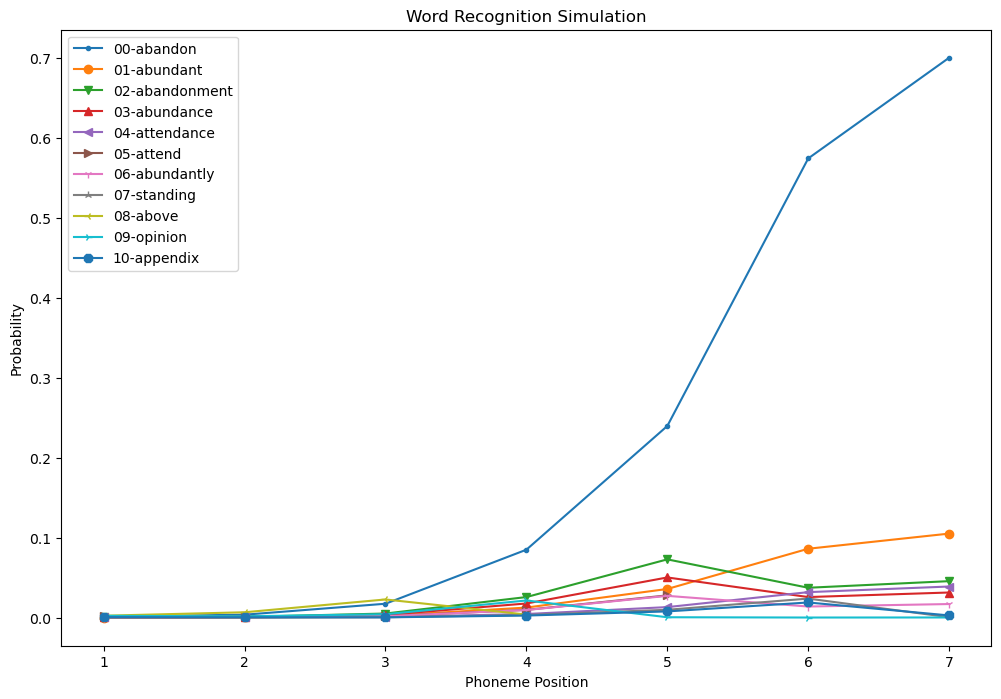

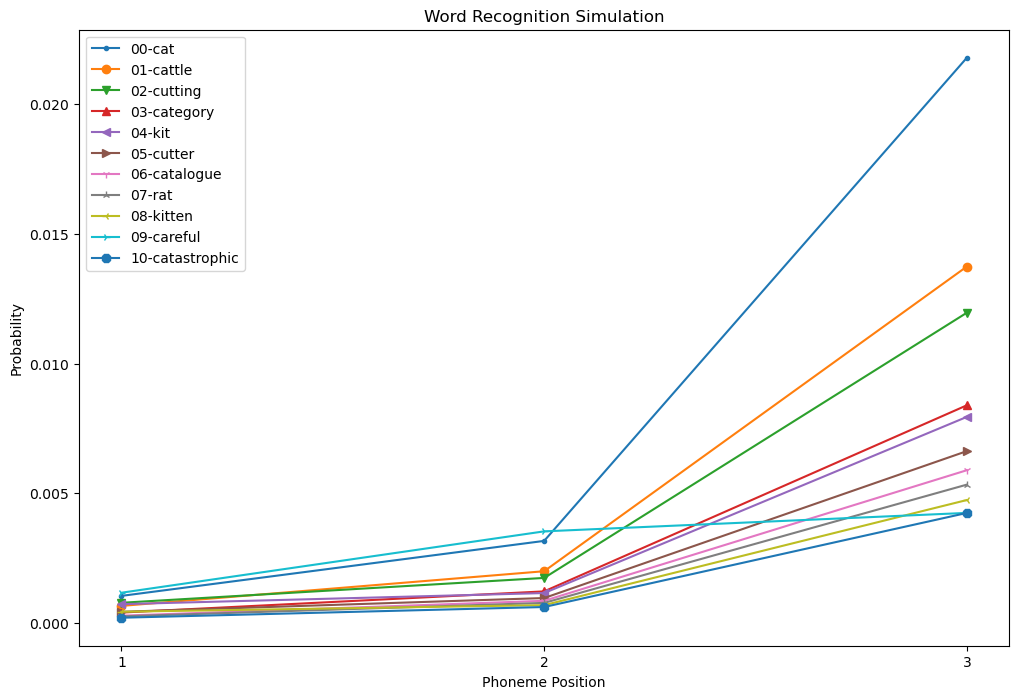

In [16]:
import matplotlib.pyplot as plt
import itertools

def plot_simulation_result(sim_result_df, log_scale=False):
    """
    Plots a line graph based on the simulation result DataFrame.
    
    Parameters:
        sim_result_df (DataFrame): The DataFrame containing simulation results.
        log_scale (bool): Whether to use a log scale for the Y-axis. Default is False.
    """
    
    marker_list = [".","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
    # Create an iterator for marker styles
    marker_iter = itertools.cycle(marker_list)
    
    # Create a figure and axis
    plt.figure(figsize=(12, 8))
    
    # Initialize an empty list to hold the legend labels and handles
    legend_labels = []
    legend_handles = []
    
    # Group the DataFrame by 'Item' and plot each group
    for name, group in sim_result_df.groupby('ItemWithOrder'):
        marker = next(marker_iter)
        line, = plt.plot(group['Phoneme Position'], group['Probability'], marker=marker, markersize=6)
        
        # Append the label and handle for this line to the lists
        legend_labels.append(name)
        legend_handles.append(line)
  
    # Add labels, title, and legend
    plt.xlabel('Phoneme Position')
    plt.ylabel('Probability')
    plt.title('Word Recognition Simulation')
    
    # Use the collected handles to create the legend in the desired order
    plt.legend(legend_handles, legend_labels)
    
    # Apply log scale if specified
    if log_scale:
        plt.yscale('log')
        
        
    # Set xticks to show only whole numbers
    plt.xticks(np.arange(min(sim_result_df['Phoneme Position']), max(sim_result_df['Phoneme Position']) + 1, 1.0))

    # Show the plot
    plt.show()

# Example usage:
plot_simulation_result(sim_abandon, log_scale=False)
plot_simulation_result(sim_cat, log_scale=False)



So we get interesting results, but things are not quite right. Probabilities for initial phonemes are very low. This is because there are so many words in the lexicon -- more than 17,000. 

Let's try a new version where we remove low-evidence items from consideration at position 1. 

In [58]:

import time
from collections import defaultdict
import pandas as pd
import numpy as np

def get_phoneme_prob_at_position(phoneme, normalized_cosine_sim_df, phoneme_prob_dict):
    
    """
    Calculate the bottom-up probability for a phoneme at a given position.
    
    Parameters:
        phoneme (str): The current phoneme.
        normalized_cosine_sim_df (DataFrame): The DataFrame containing the normalized cosine similarities between phonemes.
        phoneme_prob_dict (dict): The dictionary containing the probabilities of each phoneme.
        
    Returns:
        pd.Series: The probabilities of each phoneme at the current position.
    """
    evidence_distribution = normalized_cosine_sim_df.loc[phoneme]
    #evidence_distribution *= phoneme_prob_dict
    # Instead of multiplying the whole Series with a dictionary, use map for element-wise multiplication
    evidence_distribution = evidence_distribution.map(lambda x: x * phoneme_prob_dict.get(x, 1))

    return evidence_distribution / evidence_distribution.sum()

def sim_bayes_new(target_word, lexicon_df, normalized_cosine_sim_df, phoneme_prob_dict, topX=50):
    """
    Simulate word recognition based on Bayesian inference.
    
    Parameters:
        target_word (str): The target word to recognize.
        lexicon_df (DataFrame): The DataFrame containing the lexicon.
        normalized_cosine_sim_df (DataFrame): The DataFrame containing the normalized cosine similarities between phonemes.
        phoneme_prob_dict (dict): The dictionary containing the probabilities of each phoneme.
        
    Returns:
        pd.DataFrame: The DataFrame containing the simulation results.
    """
    # Initialize
    start_time = time.time()
    target_pronunciation = lexicon_df.loc[lexicon_df['Item'] == target_word, 'Pronunciation'].values[0]
    target_phonemes = target_pronunciation.split()
    result_list = []
    phoneme_prob_list = []  # New list to store phoneme probabilities

    total_frequency = lexicon_df['lfrq'].sum()
    word_prob_dict = {row['Item']: row['lfrq'] / total_frequency for index, row in lexicon_df.iterrows()}
    
    # Loop through each phoneme in the target word
    for phoneme_pos, phoneme in enumerate(target_phonemes, 1):
        # Step 1: Get the bottom-up probability for the phoneme
        phoneme_prob_at_pos = get_phoneme_prob_at_position(phoneme, normalized_cosine_sim_df, phoneme_prob_dict)
        # Store the phoneme probabilities in the new list
        for p, prob in phoneme_prob_at_pos.items():
            phoneme_prob_list.append({'Phoneme Position': phoneme_pos, 'Phoneme': p, 'Probability': prob})
            #print(f'     ##### Phoneme Position {phoneme_pos}, Phoneme {p}, Probability {prob}')

        # Step 2: Calculate the probability of each word's substrings (pseq)
        updated_prob_dict = defaultdict(float)
        for word, word_pronunciation in lexicon_df[['Item', 'Pronunciation']].values:
            word_phonemes = word_pronunciation.split()
            if len(word_phonemes) < phoneme_pos:
                continue
            
            pseq = 1.0
            for i in range(phoneme_pos):
                pseq *= phoneme_prob_at_pos.get(word_phonemes[i], 0)
                
            # Step 3: Multiply by word probability and update
            updated_prob_dict[word] = pseq * word_prob_dict[word]
        
        # Diagnostic prints for phoneme position 1
        # if phoneme_pos == 1:
        prob_values = list(updated_prob_dict.values())
        # print(f"Statistics before normalization at phoneme {phoneme_pos}:")
        # print(f"  Max: {max(prob_values):.15f}")
        # print(f"  Min: {min(prob_values):.15f}")
        # print(f"  Mean: {sum(prob_values) / len(prob_values):.15f}")
        # print(f"  Std: {sum((x - sum(prob_values) / len(prob_values))**2 for x in prob_values)**0.5 / len(prob_values):.15f}")

        # Sort by probability and take only top X words
        sorted_words = sorted(updated_prob_dict.items(), key=lambda x: x[1], reverse=True)[:topX]
        # Always include the target_word
        if target_word not in [word for word, _ in sorted_words]:
            sorted_words.append((target_word, updated_prob_dict.get(target_word, 0)))

        total_prob = sum([prob for word, prob in sorted_words])
        
        # Normalize only top X words
        updated_prob_dict = {word: prob / total_prob for word, prob in sorted_words}

        # Update lexicon to only include these top X words for the next phoneme
        lexicon_df = lexicon_df[lexicon_df['Item'].isin([word for word, prob in sorted_words])]
        
        # Normalize the updated probabilities
        total_prob = sum(updated_prob_dict.values())
        for word in updated_prob_dict:
            updated_prob_dict[word] /= total_prob
        
        # Diagnostic prints for phoneme position 1
        # if phoneme_pos == 1:
        # prob_values = list(updated_prob_dict.values())
        # print(f"Statistics POST normalization at phoneme {phoneme_pos}:")
        # print(f"  Max: {max(prob_values):.15f}")
        # print(f"  Min: {min(prob_values):.15f}")
        # print(f"  Mean: {sum(prob_values) / len(prob_values):.15f}")
        # print(f"  Std: {sum((x - sum(prob_values) / len(prob_values))**2 for x in prob_values)**0.5 / len(prob_values):.15f}")

        # Update word_prob_dict for next iteration
        word_prob_dict = updated_prob_dict
        
        # Create a DataFrame for this phoneme position and append to the result list
        temp_df = pd.DataFrame(list(word_prob_dict.items()), columns=['Item', 'Probability'])
        temp_df = temp_df.sort_values(by='Probability', ascending=False)
        temp_df['Phoneme Position'] = phoneme_pos
        result_list.append(temp_df)
        
        # Print the elapsed time for this phoneme
        elapsed_time = time.time() - start_time
        print(f"Time elapsed after processing phoneme {phoneme_pos}: {elapsed_time:.2f} seconds")
        
        
        
        
    # New DataFrame for phoneme probabilities
    posterior_phon_df = pd.DataFrame(phoneme_prob_list)
    
    # Combine all the DataFrames into one and return
    result_df = pd.concat(result_list, ignore_index=True)

    # Calculate peak activations for each word
    peak_activations = result_df.groupby('Item')['Probability'].max().sort_values(ascending=False).reset_index()
    
    # Select the target topX words by peak activation
    top_words = peak_activations.head(topX)
    
    # Filter final results to only include these top words
    posterior_word_df = result_df[result_df['Item'].isin(top_words['Item'])]
    
    # Create an ordered list of words based on peak activations
    sorted_words_by_peak = top_words['Item'].tolist()

    # Move the target word to the top of the list
    sorted_words_by_peak.remove(target_word)
    sorted_words_by_peak = [target_word] + sorted_words_by_peak
    
    # Create a dictionary to map each word to its index in sorted_words_by_peak, formatted as a string
    sort_order = {word: f"{index:02d}" for index, word in enumerate(sorted_words_by_peak)}
    
    # Add a new column that indicates the sort order based on peak activations
    posterior_word_df = posterior_word_df.copy()
    posterior_word_df['ItemWithOrder'] = posterior_word_df['Item'].apply(lambda x: f"{sort_order.get(x, '99')}-{x}")
    
    # Print the total elapsed time
    total_elapsed_time = time.time() - start_time
    print(f"Total time elapsed for the simulation: {total_elapsed_time:.2f} seconds")
    
    # Add a target_word column to the final result DataFrames; could help with subsequent analysis
    posterior_word_df['Target Word'] = target_word
    posterior_phon_df['Target Word'] = target_word
    
    
    return posterior_word_df, posterior_phon_df  # Return both DataFrames

# Uncomment the following lines to test the function once you have all the required DataFrames and dictionaries.
word_result, phon_result = sim_bayes_new('cat', lexicon_df, normalized_cosine_sim_df, phoneme_prob_dict)



Time elapsed after processing phoneme 1: 0.32 seconds
Time elapsed after processing phoneme 2: 0.32 seconds
Time elapsed after processing phoneme 3: 0.32 seconds
Total time elapsed for the simulation: 0.32 seconds


In [ ]:
normalized_cosine_sim_df

In [61]:
def plot_simulation_result(word_result, phon_result, log_scale=False, saveplots=False, phonplot=12, wordplot=20):
    """
    Plots a line graph based on the simulation result DataFrame and phoneme probabilities.
    
    Parameters:
        word_result (DataFrame): The DataFrame containing simulation results.
        phon_result (DataFrame): The DataFrame containing phoneme probabilities.
        log_scale (bool): Whether to use a log scale for the Y-axis. Default is False.
    """
    
    unique_words = word_result['Target Word'].unique()
    
    for word in unique_words:
        # Filter data for the current word
        word_data = word_result[word_result['Target Word'] == word]
        phon_data = phon_result[phon_result['Target Word'] == word]
        
        marker_list = [".","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
        marker_iter = itertools.cycle(marker_list)
        
        fig, axs = plt.subplots(1, 2, figsize=(18, 8))
        
        # Initialize empty lists for legend labels and handles
        word_legend_labels = []
        word_legend_handles = []
        
        # First subplot for word probabilities
        for name, group in word_data.groupby('ItemWithOrder'):
            marker = next(marker_iter)
            line, = axs[0].plot(group['Phoneme Position'], group['Probability'], marker=marker, markersize=6)
            word_legend_labels.append(name)
            word_legend_handles.append(line)
        
        axs[0].legend(word_legend_handles[:wordplot], word_legend_labels[:wordplot])
        axs[0].set_xlabel('Phoneme Position')
        axs[0].set_ylabel('Probability')
        axs[0].set_title(f'Word Recognition Simulation for {word}')
        axs[0].set_xticks(np.arange(min(word_data['Phoneme Position']), max(word_data['Phoneme Position']) + 1, 1.0))
        
        # Calculate peak activations for each phoneme
        peak_phoneme_activations = phon_data.groupby('Phoneme')['Probability'].max().sort_values(ascending=False).reset_index()
        
        # Select the topphon phonemes by peak activation
        top_phonemes = peak_phoneme_activations.head(phonplot)['Phoneme'].tolist()
        print(top_phonemes)
        
        # Initialize empty lists for legend labels and handles
        phoneme_legend_labels = []
        phoneme_legend_handles = []
        
        # Second subplot for phoneme probabilities
        for name, group in phon_data.groupby('Phoneme'):
            marker = next(marker_iter)
            line, = axs[1].plot(group['Phoneme Position'], group['Probability'], marker=marker, markersize=6)
            # Only add to the legend if the phoneme is among the topphon
            if name in top_phonemes:
                phoneme_legend_labels.append(name)
                phoneme_legend_handles.append(line)        
                
        axs[1].legend(phoneme_legend_handles[:phonplot], phoneme_legend_labels[:phonplot], title='Phonemes')
        axs[1].set_xlabel('Phoneme Position')
        axs[1].set_ylabel('Probability')
        axs[1].set_title(f'Phoneme Probabilities for {word}')
        axs[1].set_xticks(np.arange(min(phon_data['Phoneme Position']), max(phon_data['Phoneme Position']) + 1, 1.0))
        
        if log_scale:
            axs[0].set_yscale('log')
            axs[1].set_yscale('log')
        
        plt.tight_layout()
        
        if saveplots:
            # Ensure the directory exists
            if not os.path.exists('plots'):
                os.makedirs('plots')
            plt.savefig(f'plots/{word}.png')
        
        plt.show()

# Test the function
#plot_simulation_result(word_result, phon_result)


Running simulation for word: cat
Time elapsed after processing phoneme 1: 0.33 seconds
Time elapsed after processing phoneme 2: 0.33 seconds
Time elapsed after processing phoneme 3: 0.33 seconds
Total time elapsed for the simulation: 0.33 seconds
Running simulation for word: dog
Time elapsed after processing phoneme 1: 0.32 seconds
Time elapsed after processing phoneme 2: 0.32 seconds
Time elapsed after processing phoneme 3: 0.32 seconds
Total time elapsed for the simulation: 0.32 seconds
Running simulation for word: fish
Time elapsed after processing phoneme 1: 0.32 seconds
Time elapsed after processing phoneme 2: 0.32 seconds
Time elapsed after processing phoneme 3: 0.32 seconds
Total time elapsed for the simulation: 0.32 seconds
Running simulation for word: abandon
Time elapsed after processing phoneme 1: 0.32 seconds
Time elapsed after processing phoneme 2: 0.32 seconds
Time elapsed after processing phoneme 3: 0.32 seconds
Time elapsed after processing phoneme 4: 0.32 seconds
Time 

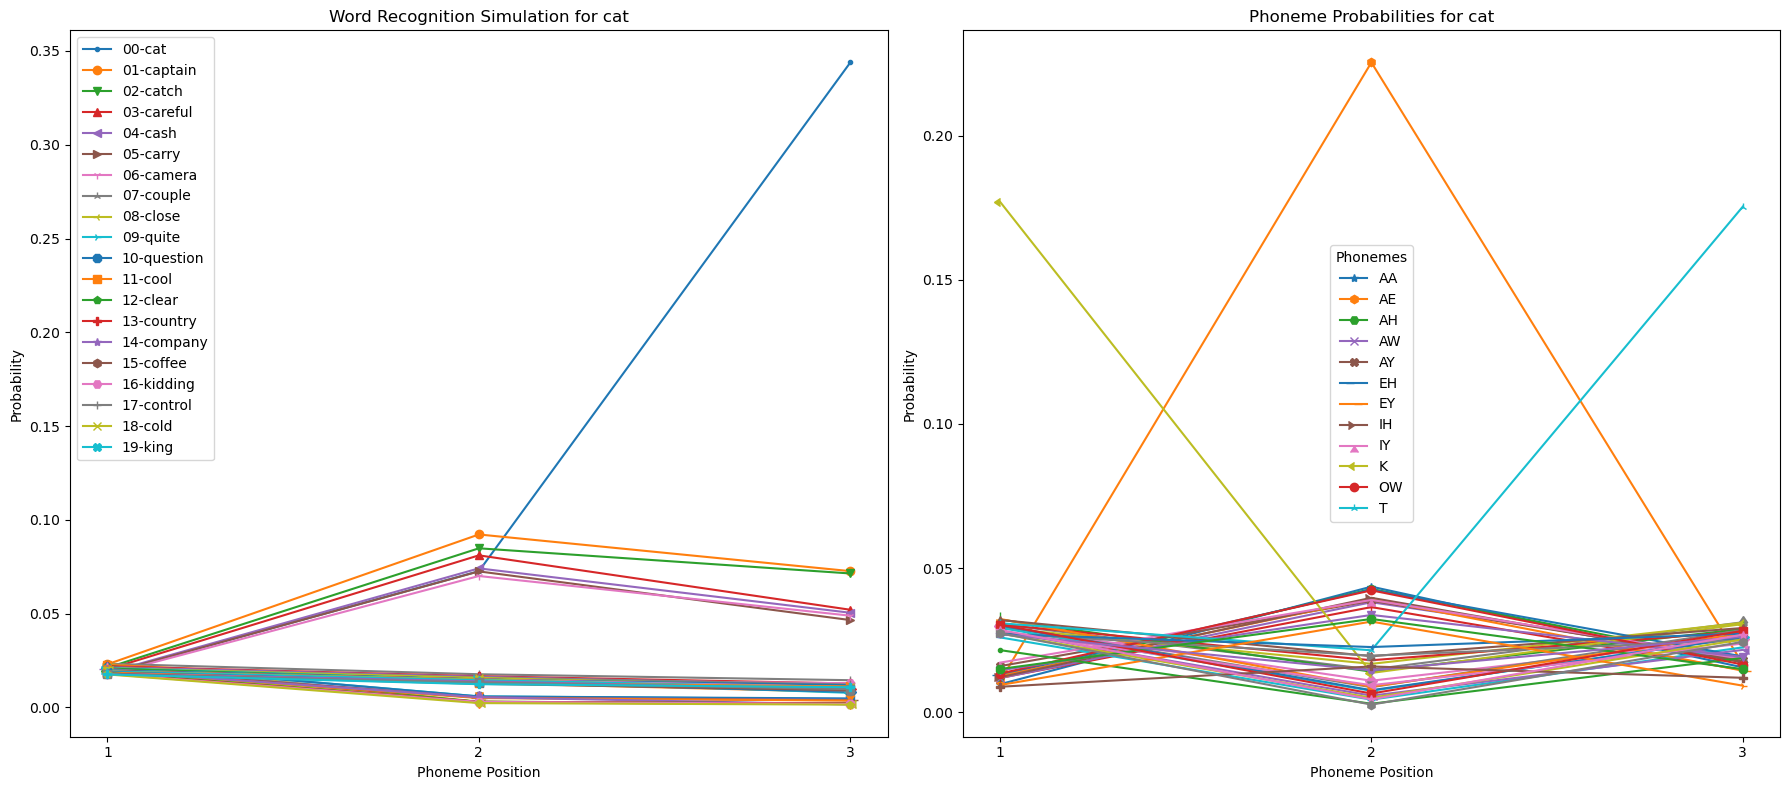

['AO', 'G', 'D', 'OW', 'AH', 'IY', 'AA', 'AE', 'EH', 'AY', 'UH', 'EY']


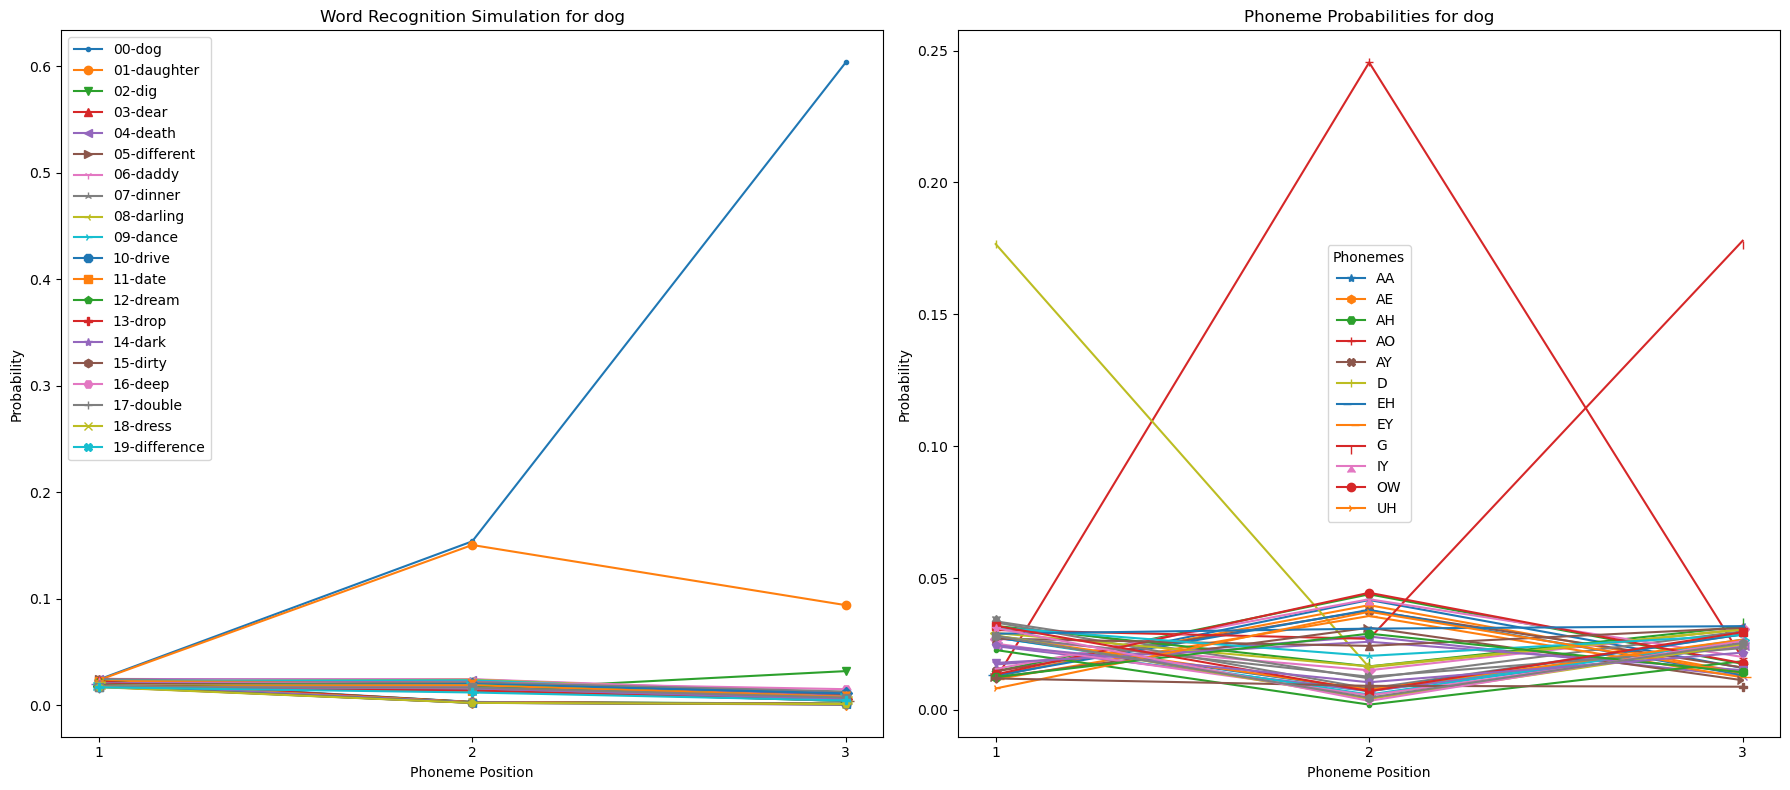

['IH', 'SH', 'F', 'EH', 'EY', 'AW', 'AE', 'AY', 'JH', 'AH', 'ZH', 'IY']


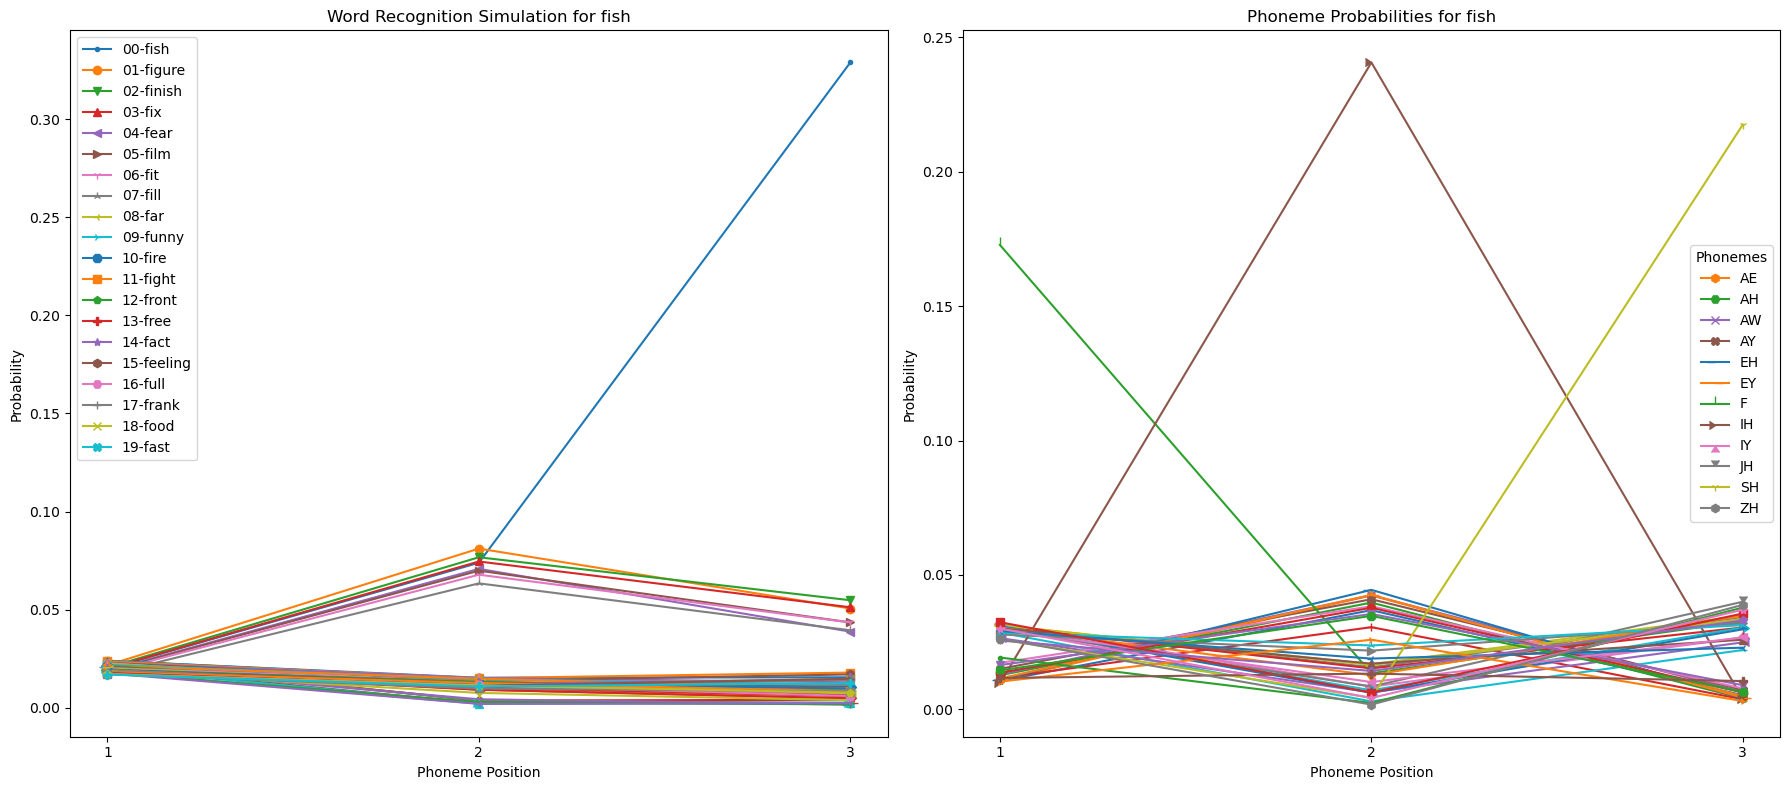

['IH', 'AE', 'AH', 'B', 'N', 'D', 'EH', 'AA', 'OW', 'EY', 'AW', 'IY']


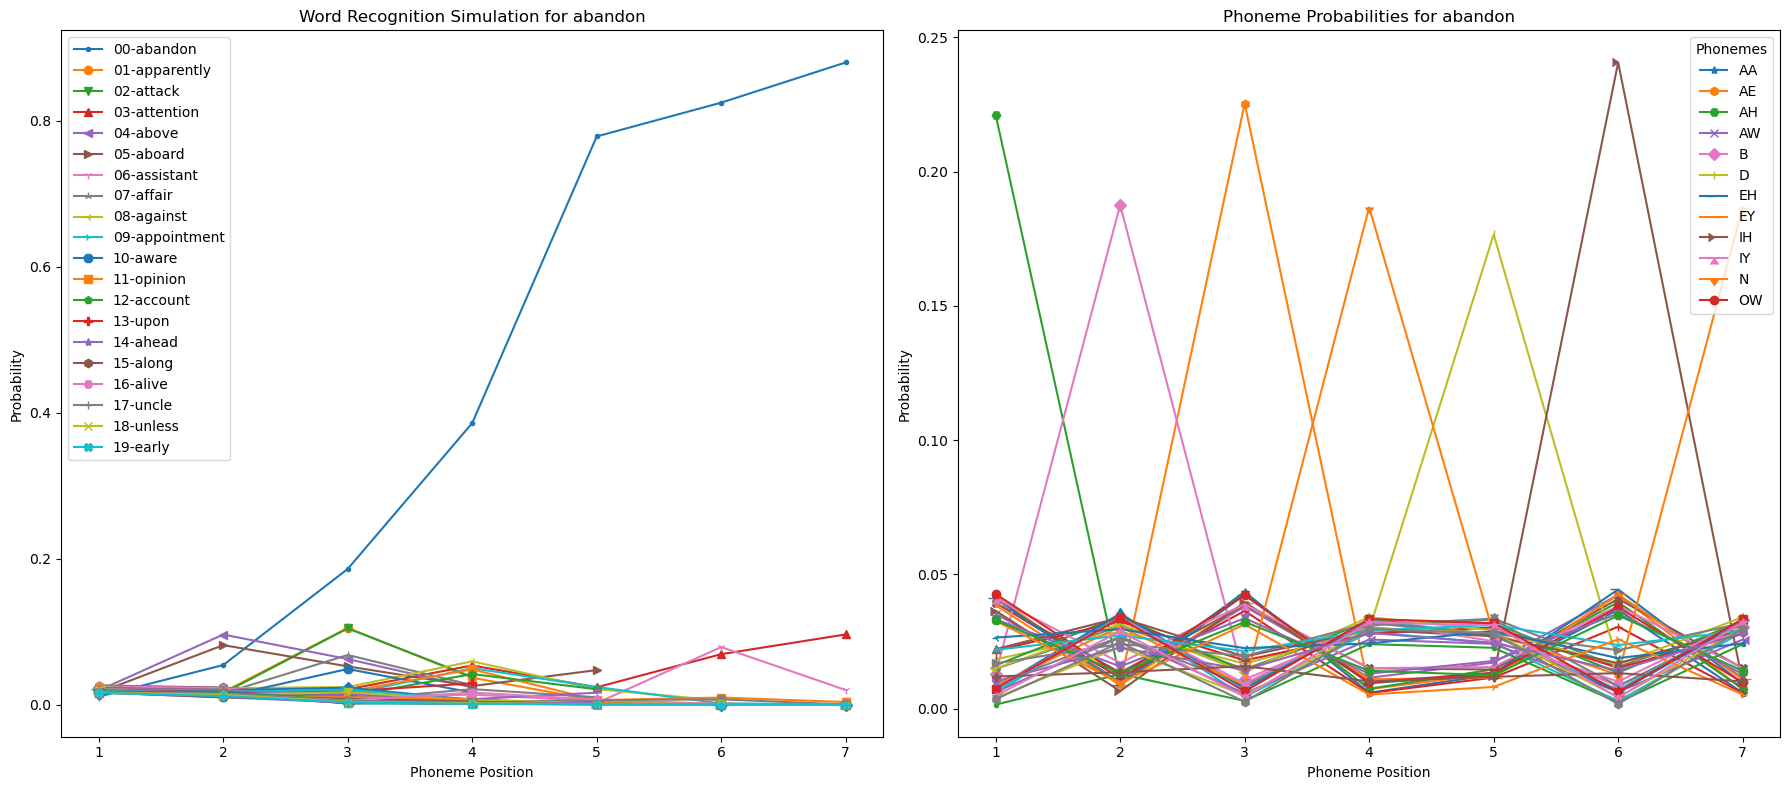

['AE', 'L', 'M', 'K', 'P', 'AA', 'AH', 'EH', 'OW', 'IH', 'EY', 'IY']


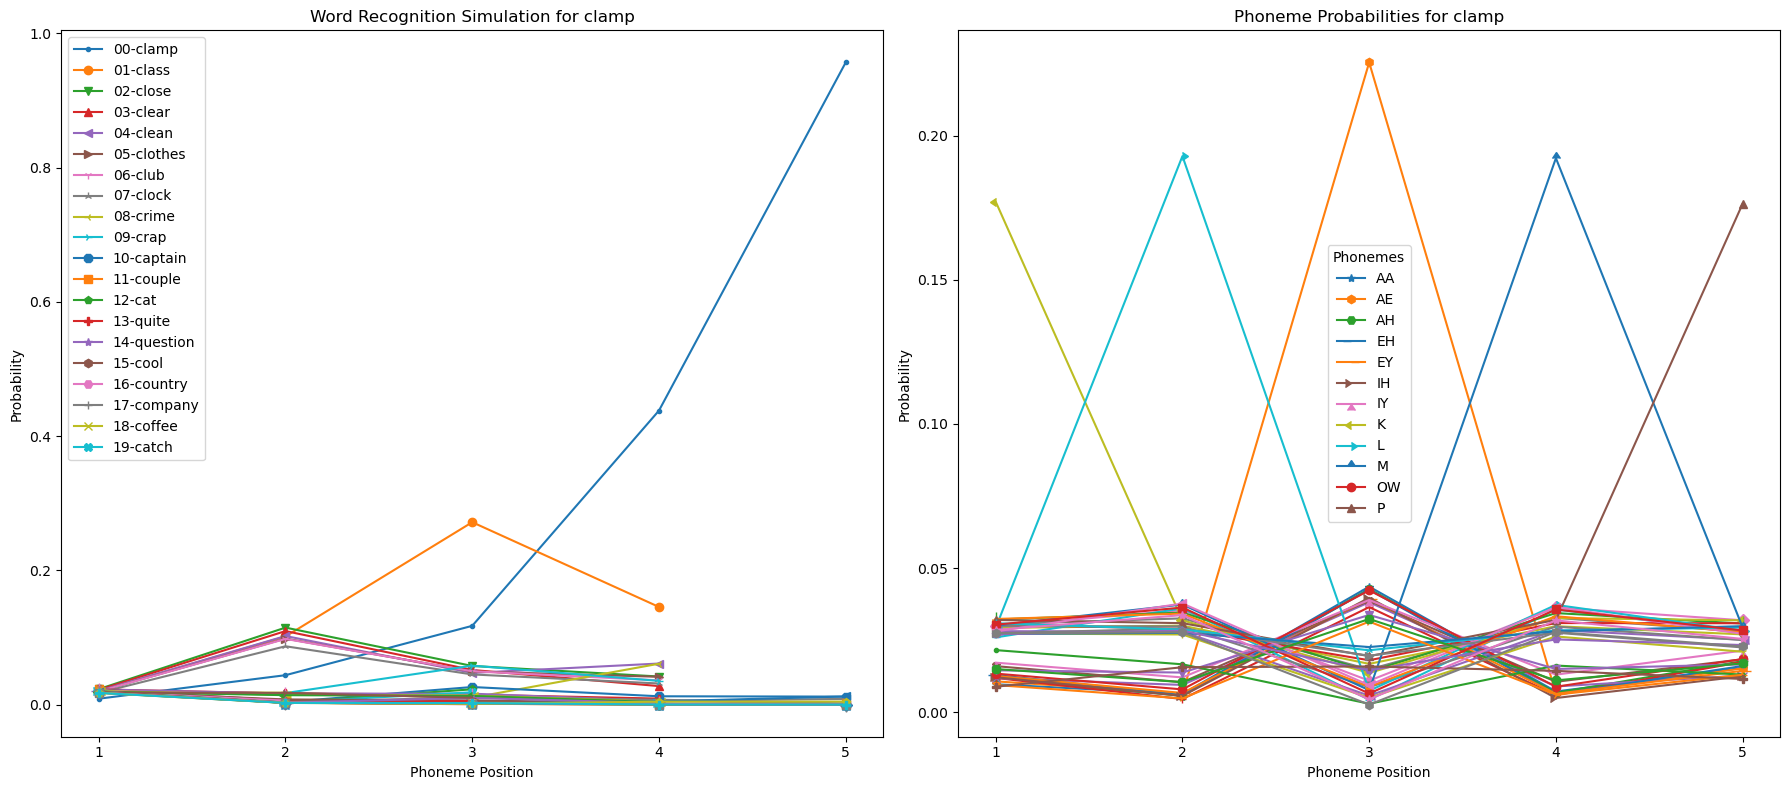

In [63]:
import pandas as pd

def run_simulations(word_list, lexicon_df, normalized_cosine_sim_df, phoneme_prob_dict, topX=50):
    """
    Runs simulations for a list of words and returns aggregated results.
    
    Parameters:
        word_list (list): List of words to simulate.
        lexicon_df (DataFrame): The DataFrame containing the lexicon.
        normalized_cosine_sim_df (DataFrame): The DataFrame containing normalized cosine similarities.
        phoneme_prob_dict (dict): Dictionary containing the probabilities of each phoneme.
        topX (int): Number of top words to consider during simulation. Default is 50.
    
    Returns:
        DataFrame, DataFrame: Aggregated word and phoneme results.
    """
    
    # Initialize empty DataFrames to store aggregated results
    aggregated_word_results = pd.DataFrame()
    aggregated_phoneme_results = pd.DataFrame()
    
    for word in word_list:
        print(f"Running simulation for word: {word}")
        word_result, phon_result = sim_bayes_new(word, lexicon_df, normalized_cosine_sim_df, phoneme_prob_dict, topX)
        
        # Append the results to the aggregated DataFrames
        aggregated_word_results = pd.concat([aggregated_word_results, word_result], ignore_index=True)
        aggregated_phoneme_results = pd.concat([aggregated_phoneme_results, phon_result], ignore_index=True)
    
    return aggregated_word_results, aggregated_phoneme_results

# Example usage:
word_list = ['cat', 'dog', 'fish', 'abandon', 'clamp']
aggregated_word_results, aggregated_phoneme_results = run_simulations(word_list, lexicon_df, normalized_cosine_sim_df, phoneme_prob_dict)
plot_simulation_result(aggregated_word_results, aggregated_phoneme_results)